In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import os
import pandas as pd
import librosa
import glob
import torch
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


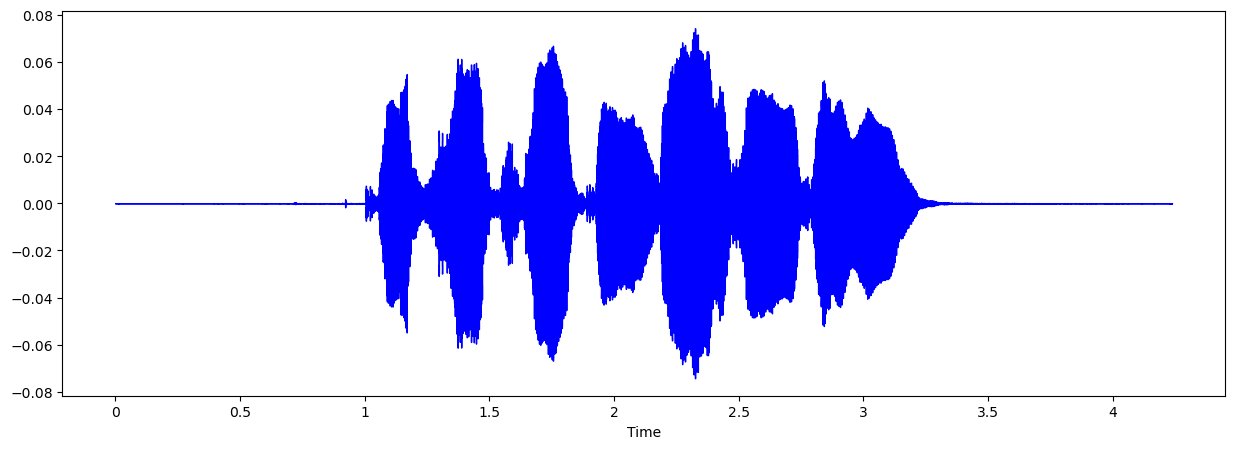

In [4]:
def plot_wave(path, sr=None):
    # Load the audio file
    data, sampling_rate = librosa.load(path, sr=sr)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(data, sr=sampling_rate, color='blue')
    plt.show()

plot_wave('RawData/03-02-01-01-01-01-01.wav')

/tmp/SLURM_22808701/ipykernel_246640/3281481209.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('RawData/03-02-01-01-01-01-01.wav')
/tmp/SLURM_22808701/ipykernel_246640/3281481209.py:23: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


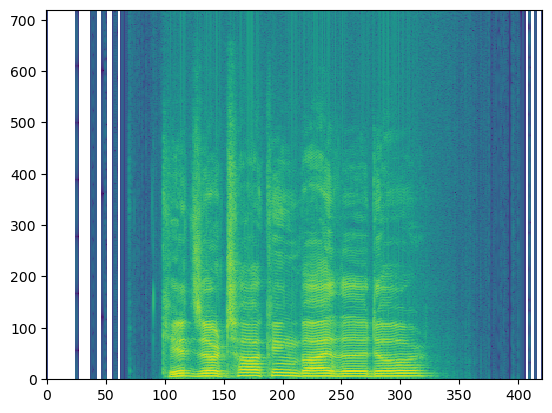

In [5]:
import scipy.io.wavfile
import sys

sr,x = scipy.io.wavfile.read('RawData/03-02-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## label set

In [6]:
'''
    It will return the list of labels base on file name and return list of file name.
    Parameters: raw_data_path --- the path of directory

'''

def get_label(raw_data_path):
    mylist = os.listdir(raw_data_path)
    raw_data_path = raw_data_path+'/'
    feeling_list=[]
    for item in mylist:
        gender_emotion = []
        if int(item[18:-4]) % 2 == 0:
            gender_emotion.append(0)
        else:
            gender_emotion.append(1)
    
        if item[6:-16] == "01":
            gender_emotion.append(2)
        elif item[6:-16] == "02":
            gender_emotion.append(3)
        elif item[6:-16] == "03":
            gender_emotion.append(1)
        elif item[6:-16] == "04":
            gender_emotion.append(5)
        elif item[6:-16] == "05":
            gender_emotion.append(8)
        elif item[6:-16] == "06":
            gender_emotion.append(6)
        elif item[6:-16] == "07":
            gender_emotion.append(7)
        elif item[6:-16] == "08":
            gender_emotion.append(4)
        feeling_list.append(gender_emotion)
    
    labels = pd.DataFrame(feeling_list)
    return labels,mylist

In [7]:
import soundfile as sf
import tensorflow_hub as hub


2024-04-15 14:40:39.042073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 14:40:43.033012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:

'''
    it will load the file and return audio data and its sample rate
    Parameters:
    file path: the auido file path
    targer_sr: resample by target_sr
    

'''

def load_audio(file_path, target_sr=16000):
    # Load the file with librosa, which automatically resamples to the target_sr
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    return audio,sample_rate

'''
    It will return the audio data with noise(erase or add more noise on audio), and sample rate
    Parameters:
    file_path: the auido file path
    noise_level: the noise value you want to add
'''
def add_noise(file_path, noise_level=1e-3):

    flip = np.random.choice([0, 1])
    #print(flip)
    #plot_wave(file_path)
    if flip == 0:
    
      audio, sr = librosa.load(file_path, sr=None)
      #print(sr)
      noise = np.random.randn(len(audio))
      augmented_audio = audio + noise_level * noise
      # Ensure that the augmented audio is within the same range as the original audio
      augmented_audio = np.clip(augmented_audio, -1, 1)
    else:
    
      audio, sr = librosa.load(file_path, sr=None)
      #print(sr)
      # part = int(len(audio)/10000)
      # noise = np.random.randn(len(audio))
      # start_part = np.random.randint(0, len(audio)-part)
      # audio[start_part:start_part+part] = audio[start_part:start_part+part] * 0
      # augmented_audio = audio
      part = int(len(audio)/50)
      noise = np.random.randn(len(audio))
      start_part = np.random.randint(int(len(audio) / 10), len(audio) - part)
      audio[start_part:start_part+part] = 0
      augmented_audio = np.clip(audio, -1, 1)
    #plot_wave(file_path,augmented_audio,sr)
    #print("============")
    return augmented_audio,sr



In [9]:
from sklearn.utils import shuffle

def combine_data(feature_vector,label_vector):
    #Assume label_vector columns name are 0 and 1
    labels = label_vector.rename(columns={0: 'Gender', 1: 'emo'})
    labels[:5]

    voice_vector = pd.DataFrame(feature_vector['feature'].values.tolist())
    all_data = pd.concat([voice_vector,labels], axis=1)
    all_data = shuffle(all_data)
    
    all_data=all_data.fillna(0)
    all_data.head()
    return all_data

In [10]:
'''
    It will return the table with feature value and their labels.
    Parameters:
    raw_data_path: the directory with audio file (Just directory name, no any audio file name)
    model_select: encoder you want to choose (Yamnet or trill)
    noise_num_rate: rate of noise audio in total number of audio files

'''

def encoder(raw_data_path,model_select,noise_num_rate,voice_vector = pd.DataFrame(columns=['feature'])):
    yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
    trill_url = "https://tfhub.dev/google/nonsemantic-speech-benchmark/trill/3"
    labels,mylist = get_label(raw_data_path)
    if noise_num_rate > 0:
        noise_num = int(len(mylist)/noise_num_rate)
    else:
        noise_num = 0
    if model_select == "yamnet":
        pre_model = hub.load(yamnet_model_handle)
    elif model_select == "trill":
        pre_model = hub.load(trill_url)
    for index,y in tqdm(enumerate(mylist), total=len(mylist),dynamic_ncols=True):
        if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
            flip = np.random.choice([0, 1])

            file_path = raw_data_path +"/"+ y
            if flip == 1 and noise_num > 0:
        
              waveform,sr = add_noise(file_path)
              noise_num -= 1
            
            else:
        
              waveform,sr = load_audio(file_path)
           
            if model_select == "trill":
                scores, embeddings, spectrogram = pre_model(waveform,sample_rate=sr)
            else:
                # Run the model
                scores, embeddings, spectrogram = pre_model(waveform)
        
           
            features = np.mean(embeddings, axis=0)
        
            # Add to the dataframe
            voice_vector.loc[index] = [features]
    all_data = combine_data(voice_vector,labels)
    return all_data


In [11]:
model_select = "yamnet"
all_data = encoder("RawData",model_select,10)

2024-04-15 14:42:19.977749: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████| 1012/1012 [04:46<00:00,  3.53it/s]


In [12]:
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,Gender,emo
657,0.022874,0.823871,0.000098,0.002885,0.009868,0.000000,0.018215,0.105110,0.017144,0.013927,...,0.000000,0.000000,0.000000,0.000000,0.025826,0.070664,0.023126,0.000000,1,8
205,0.000465,0.719919,0.055121,0.000000,0.007662,0.000000,0.009553,0.014719,0.008081,0.006235,...,0.000000,0.000000,0.000000,0.000000,0.505276,0.014174,0.003737,0.000000,0,2
483,0.287248,0.415131,0.213226,0.064905,0.370625,0.319461,0.089353,0.413479,0.372412,0.195342,...,0.452611,0.063732,0.574577,0.254508,0.399469,0.278729,0.279007,0.401219,1,3
58,0.132862,0.387540,0.151534,0.039519,0.123553,0.091659,0.086581,0.203102,0.127789,0.039092,...,0.133797,0.004581,0.193286,0.070953,0.174796,0.325184,0.093922,0.116142,0,6
740,0.174531,1.161040,0.216430,0.015063,0.271581,0.240862,0.009580,0.235037,0.243175,0.111672,...,0.327383,0.030019,0.387357,0.199468,0.277525,0.041143,0.178801,0.293008,0,3


## Shuffle the data

In [19]:
Train_data_ratio = 0.8
the_train = np.random.rand(len(all_data)) < Train_data_ratio
train = all_data[the_train]
test = all_data[~the_train]

In [20]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,Gender,emo
657,0.022874,0.823871,0.000098,0.002885,0.009868,0.000000,0.018215,0.105110,0.017144,0.013927,...,0.000000,0.000000,0.000000,0.000000,0.025826,0.070664,0.023126,0.000000,1,8
205,0.000465,0.719919,0.055121,0.000000,0.007662,0.000000,0.009553,0.014719,0.008081,0.006235,...,0.000000,0.000000,0.000000,0.000000,0.505276,0.014174,0.003737,0.000000,0,2
58,0.132862,0.387540,0.151534,0.039519,0.123553,0.091659,0.086581,0.203102,0.127789,0.039092,...,0.133797,0.004581,0.193286,0.070953,0.174796,0.325184,0.093922,0.116142,0,6
740,0.174531,1.161040,0.216430,0.015063,0.271581,0.240862,0.009580,0.235037,0.243175,0.111672,...,0.327383,0.030019,0.387357,0.199468,0.277525,0.041143,0.178801,0.293008,0,3
648,0.011839,0.493375,0.038015,0.026623,0.000025,0.000000,0.055434,0.054177,0.002180,0.003243,...,0.000000,0.002331,0.000000,0.000000,0.049230,0.019174,0.012311,0.000000,1,1


In [21]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,Gender,emo
483,0.287248,0.415131,0.213226,0.064905,0.370625,0.319461,0.089353,0.413479,0.372412,0.195342,...,0.452611,0.063732,0.574577,0.254508,0.399469,0.278729,0.279007,0.401219,1,3
833,0.322727,0.831924,0.090129,0.022813,0.497336,0.421059,0.003835,0.349718,0.452881,0.207834,...,0.575963,0.047063,0.693749,0.346177,0.166625,0.062069,0.321182,0.514079,0,5
195,0.798184,0.763393,0.260876,0.068330,1.251122,1.129648,0.027371,1.102665,1.112699,0.513811,...,1.558577,0.143093,1.882762,0.919482,0.630290,0.170467,0.818863,1.388571,1,1
950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,3
506,0.231702,0.291415,0.093565,0.038828,0.336405,0.197467,0.127317,0.200296,0.285390,0.168362,...,0.273455,0.035822,0.341950,0.165601,0.410245,0.317419,0.260869,0.239568,0,8


In [16]:
train_label = train.iloc[:,-2:]
test_label = test.iloc[:,-2:]
train_label.head()
test_label.head()

,Gender,emo
867,1,8
41,0,5
859,0,8
932,1,3
795,1,6


In [17]:
feature_train = train.iloc[:,:-2]
feature_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
518,0.077251,0.587782,0.075464,0.034429,0.078866,0.000000,0.019908,0.067984,0.043160,0.030847,...,0.000000,0.751790,0.001859,0.002530,0.019180,0.000000,0.023875,0.015421,0.094819,0.000000
101,0.000137,0.985217,0.126091,0.001452,0.006436,0.000000,0.000076,0.002824,0.008981,0.000000,...,0.000000,0.012288,0.000000,0.010084,0.000000,0.000000,0.361021,0.012368,0.018461,0.000000
335,0.316066,0.616066,0.088033,0.025305,0.380389,0.396503,0.018087,0.424599,0.398188,0.130437,...,0.064502,1.109592,0.556740,0.070575,0.704425,0.316543,0.229868,0.085838,0.250814,0.494929
537,0.158988,0.548885,0.096878,0.056649,0.116589,0.041401,0.033631,0.186479,0.153823,0.062701,...,0.003595,0.161525,0.069824,0.038782,0.131214,0.031601,0.191382,0.141508,0.110604,0.060229
959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
feature_test = test.iloc[:,:-2]
feature_test.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
867,0.260109,0.568020,0.021873,0.041798,0.265697,0.117616,0.061961,0.188300,0.268592,0.163264,...,0.071321,0.617553,0.159056,0.020838,0.209501,0.103676,0.119139,0.096550,0.194969,0.142104
41,0.840015,0.476284,0.244309,0.076383,1.207905,1.084449,0.028139,1.013769,1.096320,0.486954,...,0.301908,1.396151,1.502942,0.127300,1.836268,0.885456,0.651511,0.177140,0.758700,1.339103
859,0.262876,0.881271,0.200358,0.054325,0.308230,0.281813,0.034531,0.342728,0.338203,0.115154,...,0.027393,0.357615,0.406871,0.074900,0.520934,0.222115,0.297731,0.240406,0.132699,0.356616
932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
795,0.345989,0.450373,0.089890,0.056918,0.477158,0.384778,0.047972,0.496455,0.446403,0.226114,...,0.145695,0.895272,0.526301,0.052803,0.631736,0.321989,0.265116,0.057069,0.366860,0.469868


## process the data into encoder

In [16]:
'''
    make one-hot labels and data
'''

# import torch.nn.functional as F
# from sklearn.preprocessing import LabelEncoder

# # Assuming trainlabel, testlabel are loaded with your data
# X_train = np.array(feature_train)
# y_train = np.array(train_label)
# X_test = np.array(feature_test)
# y_test = np.array(test_label)


# # Extracting specific labels for gender and emotion from y_train and y_test
# gender_labels_train = y_train[:, 0]
# emotion_labels_train = y_train[:, 1]
# gender_labels_test = y_test[:, 0]
# emotion_labels_test = y_test[:, 1]

# # Encode gender labels
# gender_encoder = LabelEncoder()
# gender_labels_train_encoded = gender_encoder.fit_transform(gender_labels_train)
# gender_labels_test_encoded = gender_encoder.transform(gender_labels_test)  # Use transform here to avoid refitting

# # Encode emotion labels
# emotion_encoder = LabelEncoder()
# emotion_labels_train_encoded = emotion_encoder.fit_transform(emotion_labels_train)
# emotion_labels_test_encoded = emotion_encoder.transform(emotion_labels_test)  # Use transform here as well

# # Convert to PyTorch tensors
# gender_labels_train_encoded = torch.tensor(gender_labels_train_encoded)
# gender_labels_test_encoded = torch.tensor(gender_labels_test_encoded)
# emotion_labels_train_encoded = torch.tensor(emotion_labels_train_encoded)
# emotion_labels_test_encoded = torch.tensor(emotion_labels_test_encoded)

# # Convert to categorical (one-hot encoding)
# gender_labels_train_categorical = F.one_hot(gender_labels_train_encoded).float()
# gender_labels_test_categorical = F.one_hot(gender_labels_test_encoded).float()
# emotion_labels_train_categorical = F.one_hot(emotion_labels_train_encoded, num_classes=8).float()
# emotion_labels_test_categorical = F.one_hot(emotion_labels_test_encoded, num_classes=8).float()


'\n    make one-hot labels and data\n'

In [30]:
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

def make_one_hot_data(df):
    X_data = np.array(df.iloc[:,:-2])
    gender_labels = np.array(df.iloc[:,-2:-1])
    emotion_labels = np.array(df.iloc[:,-1:])
    # gender_labels = X_data[:, 0]
    # emotion_labels = X_data[:, 1]
    gender_encoder = LabelEncoder()
    gender_labels_encoded = gender_encoder.fit_transform(gender_labels)
    emotion_encoder = LabelEncoder()
    emotion_labels_encoded = emotion_encoder.fit_transform(emotion_labels)
    gender_labels_encoded = torch.tensor(gender_labels_encoded)
    emotion_labels_encoded = torch.tensor(emotion_labels_encoded)

    gender_labels_categorical = F.one_hot(gender_labels_encoded).float()
    emotion_labels_categorical = F.one_hot(emotion_labels_encoded, num_classes=8).float()

    return X_data, gender_labels_categorical, emotion_labels_categorical

In [44]:
X_train, gender_labels_train_categorical, emotion_labels_train_categorical =  make_one_hot_data(train)
X_test, gender_labels_test_categorical, emotion_labels_test_categorical = make_one_hot_data(test)

/home1/hxiao603/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home1/hxiao603/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home1/hxiao603/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home1/hxiao603/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

In [45]:
gender_labels_train_categorical
#0 ==》 【1，0】
#1 ==> [0,1]

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [46]:
emotion_labels_train_categorical

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [47]:
X_train.shape #(804, 1024)
input_n = X_train.shape[1]
print(X_train)

[[2.2873634e-02 8.2387120e-01 9.8308104e-05 ... 7.0663549e-02
  2.3125967e-02 0.0000000e+00]
 [4.6523224e-04 7.1991867e-01 5.5121209e-02 ... 1.4174460e-02
  3.7368352e-03 0.0000000e+00]
 [1.3286243e-01 3.8754031e-01 1.5153396e-01 ... 3.2518414e-01
  9.3921714e-02 1.1614249e-01]
 ...
 [1.9829524e-01 7.5355750e-01 4.1434979e-01 ... 2.4039905e-01
  2.0141307e-01 3.0395737e-01]
 [1.8829433e-02 1.0182515e+00 2.2637893e-01 ... 1.0186303e-01
  2.6960704e-02 0.0000000e+00]
 [2.9400089e-01 4.3775895e-01 1.2000213e-01 ... 7.9408884e-02
  2.0510300e-01 2.3890615e-01]]


## Make a model

In [48]:
import torch.nn as nn
class multiple_class_model(torch.nn.Module):
    def __init__(self,input_size,emo_size=8,hidden_size=256,hidden_size2=128,hidden_size3 = 64,drop_out=0.2, denseN=10,norm_type="Batch"):
        super(multiple_class_model, self).__init__()
        self.input_size = input_size #X_train.shape[1]
        self.emo_size = emo_size
        self.hidden1 = hidden_size
        self.hidden2 = hidden_size2
        self.drop_out = drop_out
        self.dense = denseN
        if norm_type == "Batch":
            self.Norm1 = nn.BatchNorm1d(hidden_size)
            self.Norm2 = nn.BatchNorm1d(hidden_size3)
        elif norm_type == "Layer":
            self.Norm1 = nn.LayerNorm(hidden_size)
            self.Norm2 = nn.LayerNorm(hidden_size3)
        self.Conv1 = nn.Conv1d(in_channels=1, 
                                out_channels=hidden_size, 
                                kernel_size=5, 
                                padding='same')
        self.maxP = nn.MaxPool1d(kernel_size=8, stride=8, padding=0)

        self.Conv2 = nn.Conv1d(in_channels=hidden_size, 
                                out_channels=hidden_size2, 
                                kernel_size=5, 
                                padding='same')

        self.Conv3 = nn.Conv1d(in_channels=hidden_size2, 
                                out_channels=hidden_size3, 
                                kernel_size=5, 
                                padding='same')
        # self.whole_model = nn.Sequential(
        #     nn.Conv1d(in_channels=input_size, 
        #                         out_channels=hidden_size, 
        #                         kernel_size=5, 
        #                         padding='same'),
        #     self.Norm1,
        #     nn.ReLU(),
        #     nn.Conv1d(in_channels=hidden_size, 
        #                         out_channels=hidden_size2, 
        #                         kernel_size=5, 
        #                         padding='same'),
        #     nn.ReLU(),
        #     nn.Dropout(p=drop_out),
        #     nn.MaxPool1d(kernel_size=8, stride=8, padding=0),
        #     nn.Conv1d(in_channels=hidden_size2, 
        #                         out_channels=hidden_size3, 
        #                         kernel_size=5, 
        #                         padding='same'),
        #     self.Norm2,
        #     nn.ReLU(),
        #     nn.Flatten()
        # )
        self.gender_linear = nn.Linear(hidden_size3 * (input_size//8),2)
        self.emo_linear = nn.Linear(hidden_size3 * (input_size//8),emo_size)

    def forward(self,x):
        # x = torch.tensor(x)
        x = x.to(device)
        #print(x.shape)
        x = x.unsqueeze(1)
        x = self.Conv1(x)
        x = self.Norm1(x)
        x = nn.ReLU()(x)
        x = self.Conv2(x)
        x = nn.Dropout(p=self.drop_out)(x)
        x = self.maxP(x)
        x = self.Conv3(x)
        x = self.Norm2(x)
        x = nn.ReLU()(x)
        x = nn.Flatten()(x)
        gender = self.gender_linear(x)
        emo = self.emo_linear(x)
        final_layer = nn.Softmax(dim=1)
        gender = final_layer(gender)
        emo = final_layer(emo)
        #print(gender)
        #print(emo)
        return emo,gender
            

In [86]:
import torch.nn as nn
class multiple_class_model(torch.nn.Module):
    def __init__(self,input_size,emo_size=8,hidden_size=256,hidden_size2=128,hidden_size3 = 64,drop_out=0.2, denseN=10,norm_type="Batch"):
        super(multiple_class_model, self).__init__()
        self.input_size = input_size #X_train.shape[1]
        self.emo_size = emo_size
        self.hidden1 = hidden_size
        self.hidden2 = hidden_size2
        self.drop_out = drop_out
        self.dense = denseN
        if norm_type == "Batch":
            self.Norm1 = nn.BatchNorm1d(hidden_size)
            self.Norm2 = nn.BatchNorm1d(hidden_size3)
        elif norm_type == "Layer":
            self.Norm1 = nn.LayerNorm(hidden_size)
            self.Norm2 = nn.LayerNorm(hidden_size3)
        self.linear1 = nn.Linear(self.input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.emo_linear = nn.Linear(hidden_size3,emo_size)
        self.gender_linear = nn.Linear(hidden_size3,2)

    def forward(self,x):
        # x = torch.tensor(x)
        x = x.to(device)
        #print(x.shape)
        x = self.linear1(x)
        x = self.Norm1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        x = nn.Dropout(p=self.drop_out)(x)
        x = self.linear3(x)
        x = self.Norm2(x)
        x = nn.ReLU()(x)
        emo = self.emo_linear(x)
        gender = self.gender_linear(x)
        final_layer = nn.Softmax(dim=1)
        gender = final_layer(gender)
        emo = final_layer(emo)
        return emo, gender
        

In [87]:
model = multiple_class_model(input_n,drop_out=0.1,norm_type="Layer")

In [88]:
model.to(device)

multiple_class_model(
  (Norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (Norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (emo_linear): Linear(in_features=64, out_features=8, bias=True)
  (gender_linear): Linear(in_features=64, out_features=2, bias=True)
)

In [89]:
#emo,gender = model(X_train) # testing

In [90]:
def loader_process(dataset):
    x,y1,y2 = zip(*dataset)
    data = torch.stack(x, dim=0)
    genders = torch.stack(y1, dim=0)
    emos = torch.stack(y2, dim=0)

    return data,genders,emos

In [91]:
class Thedataset(torch.utils.data.TensorDataset):
    def __init__(self,x,y1,y2):
        self.data = x
        self.gender = y1.to(dtype=torch.float32)
        self.emo = y2.to(dtype=torch.float32)
    
    
    def __getitem__(self,index):
        return self.data[index], self.gender[index],self.emo[index]
    
    def __len__(self):
        return len(self.data)

In [92]:
from torch.utils.data import TensorDataset, DataLoader
X_train = torch.tensor(X_train, dtype=torch.float32)
# gender_labels_train_categorical = torch.tensor(gender_labels_train_categorical, dtype=torch.float32)
# emotion_labels_train_categorical = torch.tensor(emotion_labels_train_categorical, dtype=torch.float32)
print(gender_labels_train_categorical)
train_dataset = Thedataset(X_train, gender_labels_train_categorical, emotion_labels_train_categorical)
batch_size = 30


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=loader_process,shuffle=True)
X_test = torch.tensor(X_test, dtype=torch.float32)
valid_dataset = Thedataset(X_test,gender_labels_test_categorical,emotion_labels_test_categorical)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=1, collate_fn=loader_process,shuffle=False)

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])


/tmp/SLURM_22808701/ipykernel_246640/2137689152.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/SLURM_22808701/ipykernel_246640/2137689152.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


In [93]:
import torch.optim 
epoches = 500
lr = 0.01
l1_value = 0.02
l2_value = 0
l1_switch = True
l2_switch = False
weight_decay = 1e-6

use_best_model = False

weight_gender = 0.002
assert weight_gender < 1
weight_emo = 1-weight_gender

In [94]:
def l1_regularization(model, lambda_l1):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

def l2_regularization(model, lambda_l2):
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    return lambda_l2 * l2_norm

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
loss_train_collect = []
loss_valid_collect = []
loss_f = nn.CrossEntropyLoss()
bar = tqdm(total=epoches)
lowest_loss = float('inf')
for t in range(0,epoches):
    accumulated_loss = 0
    for data, g, emo in train_loader:
        opt.zero_grad()
        e_label,g_label = model(data)
        g = g.to(device)
        # print(g_label)
        # print(g)
        emo = emo.to(device)
        g_loss = loss_f(g_label,g) #cross
        e_loss = loss_f(e_label,emo) #cro
        total_loss = g_loss * weight_gender + weight_emo * e_loss
        l1 = l1_regularization(model,l1_value)
        l2 = l2_regularization(model,l2_value)
        if l1_switch:
            total_loss += l1
        if l2_switch:
            total_loss += l2

        total_loss.backward()
        opt.step()
        accumulated_loss += total_loss.item() * len(data)
        
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for y,g,e in valid_loader:
            y = y.to(device)
            g = g.to(device)
            e = e.to(device)
            e_label,g_label = model(y)
            g_loss = loss_f(g_label,g) #cross
            e_loss = loss_f(e_label,e) #cro
            total_loss = g_loss * weight_gender + weight_emo * e_loss
            valid_loss += total_loss.item() * len(y)
            
    valid_loss /= len(valid_loader.dataset)
    
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
        if use_best_model:
            model.load_state_dict(torch.load('best_model.pth'))
        
    train_loss = accumulated_loss / len(train_loader)
    loss_train_collect.append(train_loss)
    loss_valid_collect.append(valid_loss)
    bar.set_postfix(train_loss = train_loss, valid_loss = valid_loss)
    bar.update()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Adjust figure size as needed

# Plot training loss on the first subplot
axes[0].plot(loss_train_collect, label='Train Loss', color='blue')  # No marker, blue color
axes[0].set_title('Training Loss')  # Title for the first subplot
axes[0].set_xlabel('Epoch')  # X-axis label for the first subplot
axes[0].set_ylabel('Loss')  # Y-axis label for the first subplot
axes[0].legend()  # Add a legend to the first subplot
axes[0].grid(True)  # Add grid for better readability

# Plot validation loss on the second subplot
axes[1].plot(loss_valid_collect, label='Validation Loss', color='green')  # No marker, green color
axes[1].set_title('Validation Loss')  # Title for the second subplot
axes[1].set_xlabel('Epoch')  # X-axis label for the second subplot
axes[1].set_ylabel('Loss')  # Y-axis label for the second subplot
axes[1].legend()  # Add a legend to the second subplot
axes[1].grid(True)  # Add grid for better readability

# Display the plots
plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()
        
        

 27%|██▋       | 134/500 [00:39<01:41,  3.62it/s, train_loss=251, valid_loss=2.04]

In [96]:
test_path = "Speech"
model_select = "yamnet"
test_vector = encoder("Speech",model_select,0)
print(test_vector.shape)

  2%|▏         | 35/1440 [00:07<04:58,  4.71it/s]


KeyboardInterrupt: 

In [63]:
test_x = test_vector.iloc[:,:-2]
print(test_x.shape)
print(input_n)

(1440, 1024)
1024


In [64]:
model = multiple_class_model(input_n)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to(device)

multiple_class_model(
  (Norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv1): Conv1d(1, 256, kernel_size=(5,), stride=(1,), padding=same)
  (maxP): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (Conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (Conv3): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=same)
  (gender_linear): Linear(in_features=8192, out_features=2, bias=True)
  (emo_linear): Linear(in_features=8192, out_features=8, bias=True)
)

In [40]:
test_x = np.array(test_x)
test_y = np.array(test_y)



# Extracting specific labels for gender and emotion from y_train and y_test
gender_test = test_y[:, 0]
emotion_test = test_y[:, 1]
# Encode gender labels
gender_encoder = LabelEncoder()
gender_labels_test = gender_encoder.fit_transform(gender_test)


# Encode emotion labels
emotion_encoder = LabelEncoder()
emotion_labels_test = emotion_encoder.fit_transform(emotion_test)


# Convert to PyTorch tensors
gender_labels_test = torch.tensor(gender_labels_test)
emotion_labels_test = torch.tensor(emotion_labels_test)

# Convert to categorical (one-hot encoding)
gender_labels_test = F.one_hot(gender_labels_test).float()

emotion_labels_test = F.one_hot(emotion_labels_test, num_classes=8).float()

In [67]:
test_x, gender_labels_test,emotion_labels_test = make_one_hot_data(test_vector)

/home1/hxiao603/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home1/hxiao603/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
gender_labels_test

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [0., 1.]])

In [69]:
emotion_labels_test

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [70]:
test_x = torch.tensor(test_x, dtype=torch.float32)
# gender_labels_train_categorical = torch.tensor(gender_labels_train_categorical, dtype=torch.float32)
# emotion_labels_train_categorical = torch.tensor(emotion_labels_train_categorical, dtype=torch.float32)
testing_dataset = Thedataset(test_x, gender_labels_test, emotion_labels_test)
batch_size = 1


testing_loader = DataLoader(dataset=testing_dataset, batch_size=batch_size, collate_fn=loader_process,shuffle=False)

In [71]:

gender_diff = 0
emo_acc = 0
emo_diff = 0 
with torch.no_grad():
    for y,g,e in testing_loader:
        y = y.to(device)
        e_label,g_label = model(y)
        e_label = e_label.cpu()
        g_label = g_label.cpu()
        e_label = e_label.numpy()
        e = e.cpu()
        e = e.numpy()
        correct_e = e.argmax(axis=1)
        index = correct_e[0]
        select = e_label[0][index]
        choose = e[0][index]
        e_diff = choose - select
        emo_diff += e_diff
        select_e = e_label.argmax(axis=1)
        if select_e == correct_e:
            emo_acc +=1
        #print(select_e)
        # index = selected_e
        
        # print(emo_diff)
        # print(e)
        # print(e_label)
        # print("==============")
print(emo_diff/len(testing_loader))
print(emo_acc/len(testing_loader))
        


[3]
[3]
[3]
[4]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[4]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[4]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[4]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[4]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[4]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[4]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
